In [1]:
import pandas as pd
from climtas.nci import GadiClient
import xarray as xr
import datetime as dt
import numpy as np
import dask.array as da

In [2]:
GadiClient()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45363,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:43795,Total threads: 1
Dashboard: /proxy/37367/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:42517,


### First set up bounds of data to load in for AUS2200

In [3]:
#Define lat lon slices (in this case, essentially the whole AUS2200 domain
lon_slice = slice(108,158.98)
lat_slice = slice(-45.7,-6.831799)  

#Define times to slice
t1="2016-01-21 12:00"
t2="2016-01-22 12:00"

#Because boundary layer height data (zmla) is offset by 30 minutes compared with U and V wind data,
# define a separate time slice for later centering
dt_hours=1
t1_zmla = pd.to_datetime(t1) + dt.timedelta(hours=-dt_hours)
t2_zmla = pd.to_datetime(t2) + dt.timedelta(hours=dt_hours)

#We will need to destagger the U and V winds, so we need to load in an extra grid point in lat
# and lon for v and u, respectively. Set up these slices now
dx = 0.022   #Grid spacing in degrees lat-lon
u_lon_slice=slice(lon_slice.start,lon_slice.stop+dx)
v_lat_slice=slice(lat_slice.start,lat_slice.stop+dx)  

### Load in the data and destagger U and V winds, as well as boundary layer heights 
(I got a tip that interpolation is not necessary seeing as the data just needs to be centered)

In [4]:
def load_aus2200_variable(vnames, t1, t2, exp_id, lon_slice, lat_slice, freq, hgt_slice=None, chunks="auto"):

    '''
    Load static fields for the mjo-enso AUS2200 experiment, stored on the ua8 project

    ## Input

    * vnames: list of names of aus2200 variables

    * t1: start time in %Y-%m-%d %H:%M"

    * t2: start time in %Y-%m-%d %H:%M"
    
    * exp_id: string describing the experiment. either 'mjo-elnino', 'mjo-lanina' or 'mjo-neutral'

    * lat_slice: a slice to restrict lat domain

    * lon_slice: a slice to restrict lon domain

    * freq: time frequency (string). either "10min", "1hr", "1hrPlev"

    * hgt_slice: a slice to restrict data in the vertical (in m)

    * chunks: dict describing the number of chunks. see xr.open_dataset
    '''

    assert exp_id in ['mjo-elnino', 'mjo-lanina', 'mjo-neutral'], "exp_id must either be 'mjo-elnino', 'mjo-lanina' or 'mjo-neutral'"
    assert freq in ["10min", "1hr", "1hrPlev"], "exp_id must either be '10min', '1hr', '1hrPlev'"

    out = []
    for vname in vnames:

        fnames = "/g/data/ua8/AUS2200/"+exp_id+"/v1-0/"+freq+"/"+vname+"/"+vname+"_AUS2200_"+exp_id+"_*.nc"
        ds = xr.open_mfdataset(fnames, chunks=chunks).sel(lat=lat_slice,lon=lon_slice,time=slice(t1,t2))
        if hgt_slice is not None:
            ds = ds.sel(lev=hgt_slice)
        out.append(ds[vname])

    return out

#Load model level wind data for the sea breeze index
aus2200_ua = load_aus2200_variable(["ua"],t1,t2,"mjo-elnino",u_lon_slice,lat_slice,"1hr",hgt_slice=slice(0,5000),chunks="auto")[0]
aus2200_va = load_aus2200_variable(["va"],t1,t2,"mjo-elnino",lon_slice,v_lat_slice,"1hr",hgt_slice=slice(0,5000),chunks="auto")[0]

In [5]:
def load_aus2200_static(exp_id,lon_slice,lat_slice,chunks="auto"):

    '''
    Load static fields for the mjo-enso AUS2200 experiment, stored on the ua8 project

    ## Input
    * exp_id: string describing the experiment. either 'mjo-elnino', 'mjo-lanina' or 'mjo-neutral'

    * lat_slice: a slice to restrict lat domain

    * lon_slice: a slice to restrict lon domain
    '''

    assert exp_id in ['mjo-elnino', 'mjo-lanina', 'mjo-neutral'], "exp_id must either be 'mjo-elnino', 'mjo-lanina' or 'mjo-neutral'"
    
    orog = xr.open_dataset("/g/data/ua8/AUS2200/"+exp_id+"/v1-0/fx/orog/orog_AUS2200_"+exp_id+"_fx.nc",chunks=chunks).\
            sel(lat=lat_slice,lon=lon_slice)
    lsm = xr.open_dataset("/g/data/ua8/AUS2200/"+exp_id+"/v1-0/fx/lmask/lmask_AUS2200_"+exp_id+"_fx.nc",chunks=chunks).\
            sel(lat=lat_slice,lon=lon_slice)

    return orog.orog, ((lsm.lmask==100)*1)

#Destagger by centering v wind in lat and u wind in lon
lsm = orog, lsm = load_aus2200_static("mjo-elnino",lon_slice,lat_slice)
aus2200_va = (aus2200_va.isel(lat=slice(0,-1)).assign_coords({"lat":lsm.lat}) +
                aus2200_va.isel(lat=slice(1,aus2200_va.lat.shape[0])).assign_coords({"lat":lsm.lat})) / 2
aus2200_ua = (aus2200_ua.isel(lon=slice(0,-1)).assign_coords({"lon":lsm.lon}) +
                aus2200_ua.isel(lon=slice(1,aus2200_ua.lon.shape[0])).assign_coords({"lon":lsm.lon})) / 2
aus2200_wind = xr.Dataset({"u":aus2200_ua, "v":aus2200_va})

In [6]:
#Load in boundary layer heights
aus2200_zmla = load_aus2200_variable(["zmla"],t1_zmla,t2_zmla,"mjo-elnino",lon_slice,lat_slice,"1hr",chunks="auto")[0]

In [7]:
#Centre the data in time (offset by one hour compared with u and v wind data)
aus2200_zmla = (aus2200_zmla.isel(time=slice(0,-1)).assign_coords({"time":aus2200_ua.time}) +
                aus2200_zmla.isel(time=slice(1,aus2200_zmla.time.shape[0])).assign_coords({"time":aus2200_ua.time})) / 2

### Now calculate the sea breeze index (SBI). Firstly, without subtracting the daily mean (subtract_mean=False)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 77.72 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


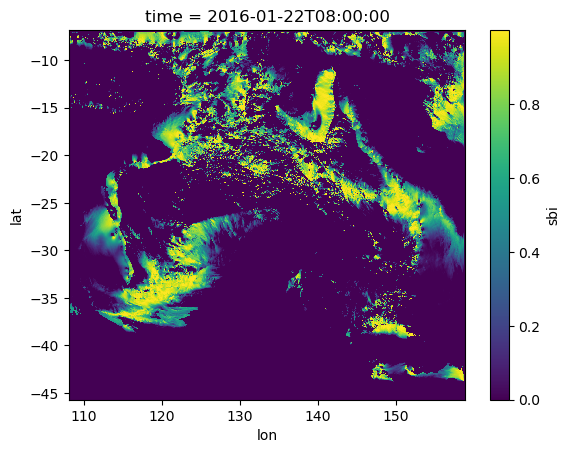

In [8]:
def calc_sbi(wind_ds,
                    angle_ds,
                    subtract_mean=False,
                    height_mean=True,
                    blh_da=None,
                    alpha_height=0,
                    sb_heights=[500,2000],
                    mean_heights=[0,4500],
                    height_method="blh",
                    blh_rolling=0,
                    vert_coord="height"):

    '''
    Take a xarray dataset of u and v winds, as well as a dataset of coastline angles, and apply the algorithm of Hallgren et al. (2023) to compute the sea breeze index via a single-column method.

    ### Input
    * wind_ds: An xarray dataset with "u" and "v" wind component variables, and a vertical coordinate "height" in metres

    * angle_ds: An xarray dataset of coastline orientation angles (degrees from N) 

    * subtract_mean: Boolean option for whether to subtract the mean background wind, and calculate perturbation sbi and lbi. Currently using an arithmatic mean over mean_heights layer

    * height_mean: Boolean option to control subtract_mean method. If true, subtract the height mean over mean_heights. Otherwise, subtract the daily mean

    * mean_heights: Array of size (2) that describes the bounds used to mean wind layer. Used if subtract_mean=True

    * blh_da: An xarray dataarray with boundary layer heights, also in m. Used if height_method="blh" to define heights to look for sea/land breezes.

    * alpha_height: Height level in m to define the "low-level" wind

    * sb_heights: Array of size (2) that describes the bounds used to define the upper level sea breeze height. Used if height_method="static"

    * lb_heights: Array of size (2) that describes the bounds used to define the upper level land breeze height. Used if height_method="static"

    * height_method: String used to choose the method for selecting upper level heights to define a circulation. Either "static" or "blh". "static" uses static height limits defined by lb_heights/sb_heights, blh uses the blh_ds.

    * blh_rolling: Integer used to define the number of rolling time windows over which to take the maximum. If zero then no rolling max is taken.

    ### Output
    * xarray dataset with sbi
    '''

    #Subtract the mean wind. Define mean as the mean over mean_heights m level, or the daily mean
    if subtract_mean:
        if height_mean:
            u_mean, v_mean = vert_mean_wind(wind_ds,mean_heights,vert_coord)
        else:
            u_mean, v_mean = daily_mean_wind(wind_ds)
        wind_ds["u"] = wind_ds["u"] - u_mean
        wind_ds["v"] = wind_ds["v"] - v_mean

    #Convert coastline orientation angle to the angle perpendicular to the coastline (pointing away from coast. from north)
    theta = (((angle_ds.angle_interp+180)%360-90)%360)

    #Calculate wind directions (from N) for low level (alpha) and all levels (beta)
    alpha = (90 - np.rad2deg(np.arctan2(
        -wind_ds["v"].sel({vert_coord:alpha_height},method="nearest"),
        -wind_ds["u"].sel({vert_coord:alpha_height},method="nearest")))) % 360
    beta = (90 - np.rad2deg(np.arctan2(
        -wind_ds["v"], 
        -wind_ds["u"]))) % 360
    wind_ds["alpha"] = alpha
    wind_ds["beta"] = beta

    #Calculate the sea breeze and land breeze indices
    sbi = np.cos(np.deg2rad((wind_ds.alpha - theta))) * \
            np.cos(np.deg2rad(wind_ds.alpha + 180 - wind_ds.beta))

    #Mask to zero everywhere except for the following conditions
    sb_cond = ( (np.cos(np.deg2rad((wind_ds.alpha - theta)))>0), #Low level flow onshore
            (np.cos(np.deg2rad(wind_ds.beta - (theta+180)))>0), #Upper level flow offshore
            (np.cos(np.deg2rad(wind_ds.alpha + 180 - wind_ds.beta))>0) #Upper level flow opposing
                  )
    sbi = xr.where(sb_cond[0] & sb_cond[1] & sb_cond[2], sbi, 0)

    #Return the max over some height. Either defined statically or boundary layer height
    _,_,_,hh = da.meshgrid(
        da.rechunk(da.array(wind_ds[wind_ds.u.dims[0]]),chunks={0:wind_ds.u.chunksizes[wind_ds.u.dims[0]][0]}),
        da.rechunk(da.array(wind_ds[wind_ds.u.dims[1]]),chunks={0:wind_ds.u.chunksizes[wind_ds.u.dims[1]][0]}),
        da.rechunk(da.array(wind_ds[wind_ds.u.dims[2]]),chunks={0:wind_ds.u.chunksizes[wind_ds.u.dims[2]][0]}),
        da.rechunk(da.array(wind_ds[wind_ds.u.dims[3]]),chunks={0:wind_ds.u.chunksizes[wind_ds.u.dims[3]][0]}), indexing="ij")
    wind_ds["height_var"] = (wind_ds.u.dims,hh)
    if height_method=="static":
        sbi = xr.where((sbi[vert_coord] >= sb_heights[0]) & (sbi[vert_coord] <= sb_heights[1]),sbi,0)
    elif height_method=="blh":
        if blh_rolling > 0:
            blh_da = blh_da.rolling({"time":blh_rolling}).max()
        sbi = xr.where((wind_ds.height_var <= blh_da),sbi,0)
    else:
        raise ValueError("Invalid height method")

    #Compute each index as the max in the column
    sbi = sbi.max(vert_coord)
    sbi_ds = xr.Dataset({"sbi":sbi})        

    return sbi_ds

def vert_mean_wind(wind_ds,mean_heights,vert_coord):

    """
    For an xarray dataset with u and v winds, take the vertical mean over some layer.
    """

    u_mean = wind_ds["u"].sel({vert_coord:slice(mean_heights[0],mean_heights[1])}).mean(vert_coord)
    v_mean = wind_ds["v"].sel({vert_coord:slice(mean_heights[0],mean_heights[1])}).mean(vert_coord)

    return u_mean, v_mean

def daily_mean_wind(wind_ds):

    """
    For an xarray dataset with u and v winds, take a rolling daily mean
    """

    dt_h = np.round((wind_ds.time.diff("time")[0].values / (1e9 * 60 * 60)).astype(float)).astype(int)
    time_window = int(24 / dt_h)
    min_periods = int(time_window/2)

    u_mean = wind_ds["u"].rolling(dim={"time":time_window},center=True,min_periods=min_periods).mean()
    v_mean = wind_ds["v"].rolling(dim={"time":time_window},center=True,min_periods=min_periods).mean()

    return u_mean, v_mean
    

#Need to first load in a dataset of coastline angles
#angle_ds = xr.open_dataset("/scratch/public/ab4502/aus2200_v3.nc").sel(lat=lat_slice,lon=lon_slice)
angle_ds = xr.open_dataset("/g/data/gb02/ab4502/coastline_data/aus2200_v3.nc").sel(lat=lat_slice,lon=lon_slice)

#Call function
sbi = calc_sbi(aus2200_wind,
        angle_ds,
        subtract_mean=False,
        height_mean=False,
        blh_da=aus2200_zmla,
        alpha_height=0,
        sb_heights=[500,2000],
        mean_heights=[0,4500],
        height_method="blh",
        blh_rolling=0,
        vert_coord="lev")
sbi.sbi.sel(time="2016-01-22 08:00").plot()

### When I now try with subtracting the daily mean (subtract_mean=True), things don't end well
So it appears the problem is with subtracting a rolling time mean. 

As desribed here: https://github.com/dask/dask/issues/874

In [ ]:
#Call function again, but this time subtract the daily mean u and v wind components.
#Before calling the function, rechunk to one time chunk for efficiency
sbi = calc_sbi(aus2200_wind.chunk({"time":-1,"lat":100,"lon":100}),
        angle_ds,
        subtract_mean=True,
        height_mean=False,
        blh_da=aus2200_zmla.chunk({"time":-1,"lat":100,"lon":100}),
        alpha_height=0,
        sb_heights=[500,2000],
        mean_heights=[0,4500],
        height_method="blh",
        blh_rolling=0,
        vert_coord="lev")
sbi.sbi.sel(time="2016-01-22 08:00").plot()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 84.50 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-11-29 16:47:19,525 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 3.67 GiB -- Worker memory limit: 4.50 GiB
2024-11-29 16:47:19,644 - distributed.worker.memory - WARNING - Worker is at 46% memory usage. Resuming worker. Process memory: 2.08 GiB -- Worker memory limit: 4.50 GiB
2024-11-29 16:48:11,997 - distributed.worker.memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 3.81 GiB -- Worker memory limit: 4.50 GiB
2024-11-29 16:48:11,999 - distributed.worker.memory - WARNING - Worker is at 60% memory usage. Resuming worker. Process memory: 2.71 GiB -- Worker memory limit: 4.50 GiB
2024-11-29 16:48:39,639 - distributed.worker.memor

### But even just computing the rolling time mean and saving to disk for later (to avoid dask scheduler issues) also takes a very long time

In [ ]:
time_window = 24
min_periods = 12
u_mean = aus2200_wind["u"].\
            chunk({"time":-1,"lat":100,"lon":100}).\
            rolling(dim={"time":time_window},center=True,min_periods=min_periods).\
            mean()
u_mean.to_netcdf("/scratch/gb02/ab4502/tmp/u_mean.nc")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 10.31 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
